## Preprocessing and feature extraction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


def preprocessing(i, j):
    dataframes_list = []
    for i in range(i, j+1):
        #Preprocessing
        from dateutil.parser import parse
    
        # Import as Dataframe
        dataset = pd.read_csv("S"+str(i)+".csv")

        # get the number of missing data points per column
        missing_values_count = dataset.isnull().sum()

        #Remove rows with missing values
        dataset = dataset.dropna()

        dataset['Time'] = pd.to_datetime(dataset['Time'], infer_datetime_format = True)
        indexed_dataset = dataset.set_index(['Time'])

        y = indexed_dataset['HR']

        #Feature Extraction
        #Rolling features were used because it is a widely used method for time series data to smooth out short-term fluctuations 
        #and highlight trends in between a considered time period. 

        indexed_dataset['difference'] = indexed_dataset['HR'].diff()
        
        indexed_dataset['rollmean'] = indexed_dataset['HR'].rolling(window = 60, min_periods=1).mean()
        
        indexed_dataset['rollmedian'] = indexed_dataset['HR'].rolling(window = 60, min_periods=1).median()
        
        indexed_dataset['rollstd'] = indexed_dataset['HR'].rolling(window = 60, min_periods=1).std()
        
        indexed_dataset['rollMax'] = indexed_dataset['HR'].rolling(window = 60, min_periods=1).max()
        
        indexed_dataset['rollMin'] = indexed_dataset['HR'].rolling(window = 60, min_periods=1).min()
        
        indexed_dataset['range'] = indexed_dataset['rollMax'] - indexed_dataset['rollMin']

        indexed_dataset = indexed_dataset.dropna()
        
        indexed_dataset.to_csv("SNew"+str(i)+".csv", index = True)
        

        dataframes_list.append(indexed_dataset)
            
    return dataframes_list 

training_dataset = pd.concat(preprocessing(1, 15))
training_dataset.to_csv("TrainingData_processed.csv", index = True)

test_dataset = pd.concat(preprocessing(16, 18))
test_dataset.to_csv("TestData_All.csv", index = True)

training_dataset



,HR,Attentive,difference,rollmean,rollmedian,rollstd,rollMax,rollMin,range
Time,,,,,,,,,
2022-02-26 13:00:57,81.0,Yes,3.0,79.500000,79.5,2.121320,81.0,78.0,3.0
2022-02-26 13:00:58,84.0,Yes,3.0,81.000000,81.0,3.000000,84.0,78.0,6.0
2022-02-26 13:00:59,90.0,Yes,6.0,83.250000,82.5,5.123475,90.0,78.0,12.0
2022-02-26 13:01:00,90.0,Yes,0.0,84.600000,84.0,5.366563,90.0,78.0,12.0
2022-02-26 13:01:01,92.0,Yes,2.0,85.833333,87.0,5.671567,92.0,78.0,14.0
...,...,...,...,...,...,...,...,...,...
2022-02-26 20:03:05,80.0,Yes,3.0,82.983333,81.0,6.347271,94.0,74.0,20.0
2022-02-26 20:03:06,87.0,Yes,7.0,82.950000,81.0,6.320333,94.0,74.0,20.0
2022-02-26 20:03:07,86.0,Yes,-1.0,82.916667,81.0,6.298484,94.0,74.0,20.0


In [2]:
training_dataset.shape

(54699, 9)

## Data Analysis

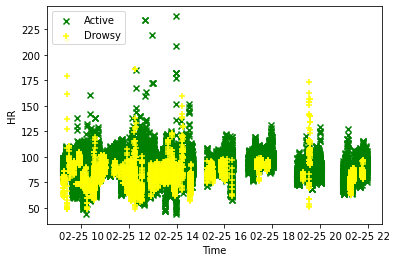

In [78]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_csv('TrainingData_processed.csv')
dataset['Time'] = pd.to_datetime(dataset['Time'], infer_datetime_format = True)

# Create a scatter plot

plt.scatter(dataset['Time'][dataset.Attentive == 'Yes'], dataset['HR'][dataset.Attentive == 'Yes'],
            color='green', marker='x', label='Active')
plt.scatter(dataset['Time'][dataset.Attentive == 'No'], dataset['HR'][dataset.Attentive == 'No'],
            color='yellow', marker='+', label='Drowsy')
plt.xlabel('Time')
plt.ylabel('HR')
plt.legend(loc='upper left')
plt.show()

## Feature selection

In [79]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X = training_dataset.iloc[:, [0, 2, 3, 4, 5, 6, 7, 8]].values
y = training_dataset.iloc[:, 1].values

X_train = X
y_train = y

X_test = test_dataset.iloc[:, [0, 2, 3, 4, 5, 6, 7, 8]].values
y_test = test_dataset.iloc[:, 1].values

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=7)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
index = ['HR', 'difference', 'rollmean', 'rollmedian', 'rollstd', 'rollMax', 'rollMin', 'range']
dfcolumns = pd.DataFrame(index)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(8,'Score'))  #print 10 best features


      Feature        Score
4     rollstd  5051.578034
7       range  4781.408190
5     rollMax  4342.223347
0          HR  3205.231128
2    rollmean  1427.176837
6     rollMin  1097.028310
3  rollmedian  1025.335767
1  difference    16.904383


## Building the model

In [3]:
X = training_dataset.iloc[:, [0, 3, 4, 5, 6, 7, 8]].values
print(X)

#X_train = X
#y_train = y

#X_test = test_dataset.iloc[:, [0, 2, 3, 4, 5, 6, 7]].values
#y_test = test_dataset.iloc[:, 1].values

[[81.         79.5        79.5        ... 81.         78.
   3.        ]
 [84.         81.         81.         ... 84.         78.
   6.        ]
 [90.         83.25       82.5        ... 90.         78.
  12.        ]
 ...
 [86.         82.91666667 81.         ... 94.         74.
  20.        ]
 [86.         82.9        81.         ... 94.         74.
  20.        ]
 [85.         82.86666667 81.         ... 94.         74.
  20.        ]]


In [4]:
y = training_dataset.iloc[:, 1].values
print(y)

['Yes' 'Yes' 'Yes' ... 'Yes' 'Yes' 'Yes']


### Normalization

In [5]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X)

# transform training data
X_normalized = norm.transform(X)
print(X_normalized)

[[0.34033613 0.555685   0.55789474 ... 0.34033613 0.78       0.015     ]
 [0.35294118 0.56616962 0.56842105 ... 0.35294118 0.78       0.03      ]
 [0.37815126 0.58189655 0.57894737 ... 0.37815126 0.78       0.06      ]
 ...
 [0.36134454 0.57956664 0.56842105 ... 0.39495798 0.74       0.1       ]
 [0.36134454 0.57945014 0.56842105 ... 0.39495798 0.74       0.1       ]
 [0.35714286 0.57921715 0.56842105 ... 0.39495798 0.74       0.1       ]]


## k-fold cross validation

In [71]:
lr_accuracy = cross_val_score(LogisticRegression(solver='liblinear'), X_normalized, y)
print(lr_accuracy)
lr_accuracy.mean()

[0.82888483 0.82367459 0.82934186 0.82212066 0.82822927]


0.8264502418513968

In [61]:
svm_accuracy = cross_val_score(SVC(kernel = 'rbf', random_state = 0), X_normalized, y)
print(svm_accuracy)
svm_accuracy.mean()

[0.83674589 0.83903108 0.84332724 0.82559415 0.84422708]


0.8377850864182346

In [20]:
knn_accuracy = cross_val_score(KNeighborsClassifier(n_neighbors=3), X_normalized, y)
print(knn_accuracy)
knn_accuracy.mean()

[0.74259598 0.78583181 0.74314442 0.69689214 0.76122132]


0.7459371338449401

In [21]:
rf_accuracy = cross_val_score(RandomForestClassifier(n_estimators = 40), X_normalized, y)
print(rf_accuracy)
rf_accuracy.mean()

[0.78747715 0.82212066 0.78583181 0.75329068 0.80939757]


0.7916235721676113

### Split data into training and testing

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size = 0.25, random_state = 0)

In [34]:
!pip install mlxtend

### Random Forest

In [84]:
# Random forest classifier
import mlxtend 
from mlxtend.evaluate import bias_variance_decomp
rf = RandomForestClassifier(n_estimators = 40)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print()
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(y_pred)


[[ 1722     6   260]
 [    1   320    35]
 [  116    13 11202]]

0.9684826325411334
                precision    recall  f1-score   support

            No       0.94      0.87      0.90      1988
Not Applicable       0.94      0.90      0.92       356
           Yes       0.97      0.99      0.98     11331

      accuracy                           0.97     13675
     macro avg       0.95      0.92      0.93     13675
  weighted avg       0.97      0.97      0.97     13675

['Yes' 'Yes' 'Yes' ... 'Yes' 'Yes' 'Yes']


### Logistic Regression

In [85]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print()
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[    0     3  1985]
 [   10    35   311]
 [    0    15 11316]]

0.830054844606947
                precision    recall  f1-score   support

            No       0.00      0.00      0.00      1988
Not Applicable       0.66      0.10      0.17       356
           Yes       0.83      1.00      0.91     11331

      accuracy                           0.83     13675
     macro avg       0.50      0.37      0.36     13675
  weighted avg       0.71      0.83      0.76     13675



### KNN

In [86]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print()
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 1716     9   263]
 [   12   308    36]
 [  231    17 11083]]

0.9584643510054844
                precision    recall  f1-score   support

            No       0.88      0.86      0.87      1988
Not Applicable       0.92      0.87      0.89       356
           Yes       0.97      0.98      0.98     11331

      accuracy                           0.96     13675
     macro avg       0.92      0.90      0.91     13675
  weighted avg       0.96      0.96      0.96     13675



### SVM

In [44]:
from sklearn.svm import SVC
SVC = SVC(kernel = 'rbf')
SVC.fit(X_train, y_train)

y_pred = SVC.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print()
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[    0    14  1971]
 [    1   211   140]
 [    0    28 11311]]

0.8424978063761334
                precision    recall  f1-score   support

            No       0.00      0.00      0.00      1985
Not Applicable       0.83      0.60      0.70       352
           Yes       0.84      1.00      0.91     11339

      accuracy                           0.84     13676
     macro avg       0.56      0.53      0.54     13676
  weighted avg       0.72      0.84      0.78     13676



## Class Imbalance

Text(0, 0.5, 'Frequency')

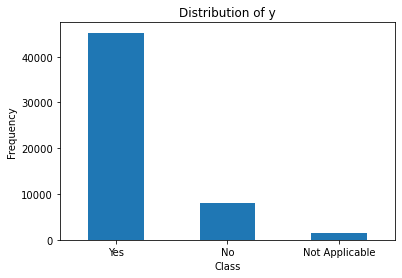

In [7]:
import matplotlib.pyplot as plt
count_classes = pd.value_counts(y, sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Distribution of y")

plt.xlabel("Class")

plt.ylabel("Frequency")

In [8]:
# class count
class_count_yes, class_count_no, class_count_na = training_dataset['Attentive'].value_counts()

# Separate class
class_0 = training_dataset[training_dataset['Attentive'] == 'Yes']
class_1 = training_dataset[training_dataset['Attentive'] == "No"]# print the shape of the class
class_2 = training_dataset[training_dataset['Attentive'] == 'Not Applicable']

print('Not drowsy:', class_0.shape[0]/(class_1.shape[0]+class_0.shape[0]+class_2.shape[0])*100,"%")
print('Drowsy:', class_1.shape[0]/(class_1.shape[0]+class_0.shape[0]+class_2.shape[0])*100, "%")
print('Not applicable data:', class_2.shape[0]/(class_1.shape[0]+class_0.shape[0]+class_2.shape[0])*100, "%")

Not drowsy: 82.71997659920657 %
Drowsy: 14.621839521746285 %
Not applicable data: 2.658183879047149 %


### SMOTE ENN

In [25]:
!pip install imbalanced-learn

  Using cached imbalanced_learn-0.9.0-py3-none-any.whl (199 kB)


In [29]:
!pip install scikit-learn

In [11]:
pip install --upgrade scikit-learn

  Using cached scikit_learn-1.0.2-cp38-cp38-win_amd64.whl (7.2 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\HP\\anaconda3\\Lib\\site-packages\\~~learn\\.libs\\vcomp140.dll'
Consider using the `--user` option or check the permissions.



### Handling imbalanced dataset

In [9]:
from typing import Counter
# import library
from imblearn.combine import SMOTEENN
counter = Counter(y_train)
print('Before',counter)
#oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()

# fit predictor and target variable
X_train_smenn, y_train_smenn = smenn.fit_resample(X_train, y_train)
counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({'Yes': 33916, 'No': 6010, 'Not Applicable': 1098})
After Counter({'Not Applicable': 33856, 'No': 33274, 'Yes': 31353})


### After handling imbalanced dataset

In [10]:
X_train = X_train_smenn
y_train = y_train_smenn

#### Random forest

In [91]:
# Random forest classifier
import mlxtend 
from mlxtend.evaluate import bias_variance_decomp
rf = RandomForestClassifier(n_estimators = 40)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print()
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(y_pred)


[[ 1649    11   328]
 [    2   340    14]
 [  370    73 10888]]

0.9416453382084095
                precision    recall  f1-score   support

            No       0.82      0.83      0.82      1988
Not Applicable       0.80      0.96      0.87       356
           Yes       0.97      0.96      0.97     11331

      accuracy                           0.94     13675
     macro avg       0.86      0.92      0.89     13675
  weighted avg       0.94      0.94      0.94     13675

['Yes' 'Yes' 'Yes' ... 'No' 'Yes' 'Yes']


#### logistic regression

In [92]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print()
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1190  133  665]
 [  39  290   27]
 [3463 1320 6548]]

0.5870566727605119
                precision    recall  f1-score   support

            No       0.25      0.60      0.36      1988
Not Applicable       0.17      0.81      0.28       356
           Yes       0.90      0.58      0.71     11331

      accuracy                           0.59     13675
     macro avg       0.44      0.66      0.45     13675
  weighted avg       0.79      0.59      0.64     13675



#### KNN

In [93]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print()
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 1660    10   318]
 [    4   343     9]
 [  725   101 10505]]

0.9146617915904937
                precision    recall  f1-score   support

            No       0.69      0.84      0.76      1988
Not Applicable       0.76      0.96      0.85       356
           Yes       0.97      0.93      0.95     11331

      accuracy                           0.91     13675
     macro avg       0.81      0.91      0.85     13675
  weighted avg       0.92      0.91      0.92     13675



#### SVM with rbf kernal

In [52]:
from sklearn.svm import SVC
SVC = SVC(kernel = 'rbf')
SVC.fit(X_train, y_train)

y_pred = SVC.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print()
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1581   50  354]
 [   9  329   14]
 [4221  424 6694]]

0.6291313249488154
                precision    recall  f1-score   support

            No       0.27      0.80      0.41      1985
Not Applicable       0.41      0.93      0.57       352
           Yes       0.95      0.59      0.73     11339

      accuracy                           0.63     13676
     macro avg       0.54      0.77      0.57     13676
  weighted avg       0.84      0.63      0.68     13676



## Hyper Parameter Tuning

### RandomizedSearchCV

In [94]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

model_params = {
   
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [200, 400, 600, 800, 1000],
            'max_depth': [2, 4, 10, 20, 50],
            'min_samples_split': [2, 5, 10, 14], 
            'criterion': ['entropy', 'gini']
        }
    }
    
}

In [95]:
from sklearn.model_selection import RandomizedSearchCV
scores = []

for model_name, mp in model_params.items():
    rscv =  RandomizedSearchCV(mp['model'], mp['params'], cv=3, return_train_score=False, n_iter=50)
    rscv.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': rscv.best_score_,
        'best_params': rscv.best_params_
    })
    
df2 = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df2

,model,best_score,best_params
0,random_forest,0.994082,"{'n_estimators': 1000, 'min_samples_split': 2,..."


In [96]:
pd.set_option("display.max_colwidth", -1)
df2

<ipython-input-96-be3b4cd8836d>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


,model,best_score,best_params
0,random_forest,0.994082,"{'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 50, 'criterion': 'entropy'}"


#### Test with Random forest (After tuning parameters with randomized search cv)

In [97]:
from sklearn.ensemble import RandomForestClassifier

#best_grid=clf.best_estimator_

best_grid = RandomForestClassifier(n_estimators = 1000, min_samples_split = 2, max_depth = 50, criterion = 'entropy')
best_grid.fit(X_train, y_train)

y_pred=best_grid.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

[[ 1647     9   332]
 [    2   341    13]
 [  352    74 10905]]
Accuracy Score 0.9428153564899452
Classification report:                 precision    recall  f1-score   support

            No       0.82      0.83      0.83      1988
Not Applicable       0.80      0.96      0.87       356
           Yes       0.97      0.96      0.97     11331

      accuracy                           0.94     13675
     macro avg       0.87      0.92      0.89     13675
  weighted avg       0.94      0.94      0.94     13675



### Grid Search CV

In [11]:
model_params2 = {
   
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [600, 800, 1000],
            'max_depth': [60, 80, 100, 120],
            'min_samples_split': [2, 3, 4], 
            'criterion': ['entropy']
        }
    }
    
}

In [12]:
from sklearn.model_selection import GridSearchCV
scores2 = []

for model_name, mp in model_params2.items():
    gscv =  GridSearchCV(mp['model'], mp['params'], cv=3, n_jobs = -1, verbose = 2, return_train_score=False)
    gscv.fit(X_train, y_train)
    scores2.append({
        'model': model_name,
        'best_score': gscv.best_score_,
        'best_params': gscv.best_params_
    })
    
df = pd.DataFrame(scores2,columns=['model','best_score','best_params'])
pd.set_option("display.max_colwidth", -1)
df

Fitting 3 folds for each of 36 candidates, totalling 108 fits


<ipython-input-12-038f93c1d242>:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


,model,best_score,best_params
0,random_forest,0.994629,"{'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 2, 'n_estimators': 800}"


In [13]:
gscv.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=100, n_estimators=800)

#### Test with Random forest (After tuning parameters with grid search cv)

In [14]:
from sklearn.ensemble import RandomForestClassifier
best_grid1 = RandomForestClassifier(criterion='entropy', max_depth=100, n_estimators=800)
best_grid1.fit(X_train, y_train)

y_pred=best_grid1.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

[[ 1839     9   140]
 [    2   342    12]
 [  394    74 10863]]
Accuracy Score 0.9538574040219379
Classification report:                 precision    recall  f1-score   support

            No       0.82      0.93      0.87      1988
Not Applicable       0.80      0.96      0.88       356
           Yes       0.99      0.96      0.97     11331

      accuracy                           0.95     13675
     macro avg       0.87      0.95      0.91     13675
  weighted avg       0.96      0.95      0.96     13675



## Write the model into a pickle file

In [15]:
import pickle
pickle.dump(best_grid1, open('modelofpulse.pkl', 'wb'))

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from dateutil.parser import parse
import datetime as datetime
from scipy import stats
from sklearn.ensemble import RandomForestClassifier    
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from typing import Counter
from imblearn.combine import SMOTEENN
    
    
#import test dataset
test_dataset = pd.read_csv('S18.csv')
    
# Preprocessing Test dataset
    
# get the number of missing data points per column
missing_values_count = test_dataset.isnull().sum()

#Remove rows with missing values
test_dataset = test_dataset.dropna()
    
test_dataset['Time'] = pd.to_datetime(test_dataset['Time'], infer_datetime_format = True)
test_dataset = test_dataset.set_index(['Time'])
    
# Feature extraction from test data
    
test_dataset['dropValue'] = test_dataset['HR'].diff()
        
test_dataset['rollmean'] = test_dataset['HR'].rolling(window = 60, min_periods=1).mean()
        
test_dataset['rollmedian'] = test_dataset['HR'].rolling(window = 60, min_periods=1).median()
        
test_dataset['rollstd'] = test_dataset['HR'].rolling(window = 60, min_periods=1).std()
        
test_dataset['rollMax'] = test_dataset['HR'].rolling(window = 60, min_periods=1).max()
        
test_dataset['rollMin'] = test_dataset['HR'].rolling(window = 60, min_periods=1).min()

test_dataset['range'] = test_dataset['rollMax'] - test_dataset['rollMin']

test_dataset = test_dataset.dropna()
test_dataset.to_csv("Test_dataset_processed.csv", index = True)
    
test_df = pd.read_csv('Test_dataset_processed.csv')
    
test_df['Time'] = pd.to_datetime(test_df['Time'], infer_datetime_format = True)
    
# Get the model from pickle file
pickled_model_pulse = pickle.load(open('modelofpulse.pkl', 'rb'))
    
# Predicting drowsy percentage for each 2 minutes   
test_df['Time']=test_df['Time'].dt.time
time1 = test_df.loc[0,'Time']
rows=0
    
DrowsyPercentageList = []
    
while ((rows+120)<len(test_df.index)):
    type(time1)
    a_datetime = datetime.datetime.combine(datetime.date.today(), time1)

    end_time = (a_datetime + timedelta(minutes = 2)).time()
    Array=test_df.index[test_df['Time']==end_time].tolist()
    rows=Array[0]
    df=test_df.loc[(test_df['Time'] >= time1) & (test_df['Time'] <= end_time)]
    df
    X_testactual = df.iloc[:, [1, 4, 5, 6, 7, 8, 9]].values
    # fit scaler on test data to normalize test data
    norm1 = MinMaxScaler().fit(X_testactual)
    # transform test data
    X_testactual_norm = norm1.transform(X_testactual)
    X_testactual_norm
    arr=pickled_model_pulse.predict(X_testactual_norm)
    arr2=df.iloc[:, 2].values
    arr
    count=0
    count2=0
    for label in arr:
        if(label=='No'):
            count = count+1
    for label2 in arr2:
        if(label2=='No'):
            count2 = count2+1        
        
    PredictedDrowsyPercentage=round((count/len(arr)*1000), 2)
    ActualDrowsyPercentage=round((count2/len(arr)*100), 2)
    
    DrowsyPercentageList.append({
    'Starting time': time1,
    'Ending time': end_time,
    'Predicted Drowsy Percentage(%)': round(PredictedDrowsyPercentage, 2),
    'Actual Drowsy Percentage': round(ActualDrowsyPercentage, 2),
    })
    print(str(time1) + " " + str(PredictedDrowsyPercentage) + "%")
        
    time1=end_time
    
df1 = pd.DataFrame(DrowsyPercentageList,columns=['Starting time','Ending time','Predicted Drowsy Percentage(%)'])
df1 = df1.set_index(['Starting time'])
    
df1.to_csv("DrowsyPercentage_Pulsesensor.csv", index = True)
    
df1

#pickle.dump( DrowsyPercentageList, handle)

   

16:15:21 0.0%
16:17:21 33.06%
16:19:21 0.0%
16:21:21 0.0%
16:23:21 0.0%
16:25:21 0.0%
16:27:21 0.0%
16:29:21 0.0%
16:31:21 0.0%
16:33:21 8.26%
16:35:21 0.0%
16:37:21 0.0%
16:39:21 41.32%
16:41:21 0.0%
16:43:21 0.0%
16:45:21 0.0%
16:47:21 0.0%
16:49:21 24.79%
16:51:21 8.26%
16:53:21 0.0%
16:55:21 8.26%
16:57:21 33.33%
16:59:21 49.59%
17:01:21 0.0%
17:03:21 0.0%
17:05:21 0.0%
17:07:21 0.0%
17:09:21 0.0%
17:11:21 0.0%
17:13:21 8.26%


,Ending time,Predicted Drowsy Percentage(%)
Starting time,,
16:15:21,16:17:21,0.00
16:17:21,16:19:21,33.06
16:19:21,16:21:21,0.00
16:21:21,16:23:21,0.00
16:23:21,16:25:21,0.00
16:25:21,16:27:21,0.00
16:27:21,16:29:21,0.00
16:29:21,16:31:21,0.00
16:31:21,16:33:21,0.00
